# Pruning a tree-based model

 
### Classification problem


In [1]:
# Import libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np 

In [5]:
# Import data
df = pd.read_csv('spam_uci.csv', delimiter = ",")

In [4]:
# Explore the size of the data set
df.shape

(4601, 8)

In [6]:
# Explore the types of data and feature names
df.head()

,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
0,1,278,0.000,0.778,0.00,0.00,0.00,y
1,2,1028,0.180,0.372,0.43,0.43,0.21,y
2,3,2259,0.184,0.276,0.06,1.16,0.06,y
3,4,191,0.000,0.137,0.00,0.00,0.00,y
4,5,191,0.000,0.135,0.00,0.00,0.00,y


### Metadata

| Variable | Description
| :--------|:-----------------------------------------------------------------|
| crl.tot  | Total number of capital letters in the e-mail                    |
| dollar   | Percentage of characters in the e-mail that match the “$” symbol |
| bang	   | Percentage of characters in the e-mail that match the “!” symbol    |   
| money	   | Percentage of words in the e-mail that match the word “money”  |
| n000	   | Percentage of strings in the e-mail that match the string “000”  |
| make	   | Percentage of words in the e-mail that match the word “make”   |
| yesno	   | “n” for not spam and “y” for spam          |

The `yesno` variable will be the response variable.




In [7]:
# Explore further
print("Number of emails classified as spam:",len(df[df.yesno == 'y']))
df.sample(10, random_state=0)

Number of emails classified as spam: 1813


,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
991,992,1351,0.158,0.491,0.10,0.60,0.1,y
2565,2566,4,0.000,0.000,0.00,0.00,0.0,n
1906,1907,15,0.000,0.000,0.00,0.00,0.0,n
1471,1472,158,0.290,0.000,0.32,0.98,0.0,y
1813,1814,5902,0.022,0.022,0.00,0.00,0.0,n
2100,2101,5,0.000,0.000,0.00,0.00,0.0,n
3106,3107,8,0.000,0.000,0.00,0.00,0.0,n
4235,4236,28,0.000,0.000,0.00,0.00,0.0,n
1095,1096,274,0.000,0.140,0.58,0.00,0.0,y
3462,3463,130,0.000,0.122,0.00,0.00,0.0,n


In [9]:
# Split data into features (X) and response (y)
# Given that the response is categorial, this is a classification problem
# Note that the column names need to have quotation marks
X = df.iloc[:, 1:7]
y = df.loc[:, ["yesno"]]

In [10]:
X.head()

,crl.tot,dollar,bang,money,n000,make
0,278,0.000,0.778,0.00,0.00,0.00
1,1028,0.180,0.372,0.43,0.43,0.21
2,2259,0.184,0.276,0.06,1.16,0.06
3,191,0.000,0.137,0.00,0.00,0.00
4,191,0.000,0.135,0.00,0.00,0.00


In [8]:
y.head()

,yesno
0,y
1,y
2,y
3,y
4,y


Before training the model, it will be split into a training and test set, so the accuracy of the model can be determined before pruning.

In [9]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape,X_test.shape)

# Fit data to tree-based classification model
classifier = DecisionTreeClassifier(random_state=0) 
classifier.fit(X_train, y_train)

# View accuracy prior to pruning
y_pred = classifier.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

# Print the test score
print("Accuracy score of the tree = {:2.2%}".format(test_score)) 

(3450, 6) (1151, 6)
Accuracy score of the tree = 86.10%


A model fitted without constraints has an accuracy of 86.10%. The model is likely overfitted on the data, with terminal nodes having as little as one sample.

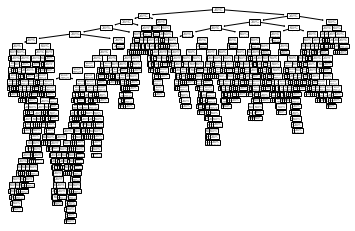

In [10]:
# Plot of full tree
plt.figure()
plot_tree(classifier,feature_names=X.columns)
plt.show()

In [11]:
print("Tree depth =",classifier.get_depth(),'\n'
      "Number of leaves =",classifier.get_n_leaves())

Tree depth = 35 
Number of leaves = 502


To prevent the model from overfitting, the number of samples in each terminal node or leaf can be restricted.





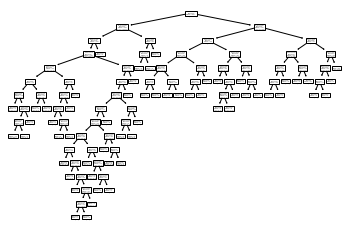

Number of leaves = 57


In [12]:
# Plot a more simplified tree, requiring a minimum of 40 samples in each 
# terminal node or leaf
classifier_small = DecisionTreeClassifier(random_state=0, 
                                          min_samples_leaf=40) 
# The default for min_samples_leaf is 1
classifier_small.fit(X_train, y_train)
plt.figure()
plot_tree(classifier_small,feature_names=X.columns)
plt.show()
print("Number of leaves =",classifier_small.get_n_leaves())

So how do you determine the optimal tree size? That is, how do you decide on the minimum number of samples you want in each terminal node?

In [13]:
# Finding the optimal number of samples per leaf
samples = [sample for sample in range(1,50)]     

classifiers = []
for sample in samples:
    classifier2 = DecisionTreeClassifier(random_state=0, 
                                         min_samples_leaf=sample)
    classifier2.fit(X_train, y_train)
    classifiers.append(classifier2)

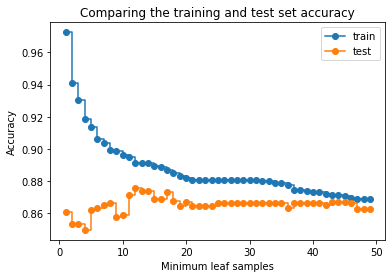

In [16]:
# Visualise the performance of each subtree on the training and test sets
train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]

fig, ax = plt.subplots()
ax.set_xlabel("Minimum leaf samples")
ax.set_ylabel("Accuracy")
ax.set_title("Comparing the training and test set accuracy")
ax.plot(samples, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(samples, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

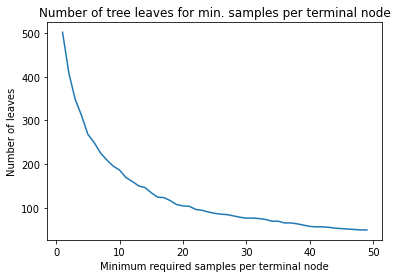

In [14]:
# Visualise how drastically the tree gets pruned by increasing the minimum 
# required samples per terminal node
nr_leaves = [clf.get_n_leaves() for clf in classifiers]

plt.figure()
plt.xlabel("Minimum required samples per terminal node")
plt.ylabel("Number of leaves")
plt.title("Number of tree leaves for min. samples per terminal node")
plt.plot(samples,nr_leaves)
plt.show()

In [15]:
# In order to find the optimal minimum leaf samples, cross validation is applied
validation_scores = []
for sample in samples:
    classifier3 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier3, X=X_train, y=y_train, cv=5)   
    validation_scores.append(score.mean())

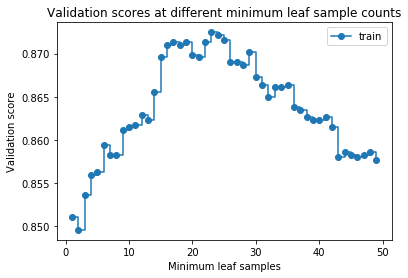

In [19]:
# Visualise the validation score in relation to minimum leaf samples.
plt.figure()
plt.xlabel("Minimum leaf samples")
plt.ylabel("Validation score")
plt.title("Validation scores at different minimum leaf sample counts")
plt.plot(samples, validation_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.legend()
plt.show()

In [16]:
# Obtain the minimum leaf samples with the highest validation score.
samples_optimum = samples[validation_scores.index(max(validation_scores))]
print(samples_optimum)

23


A minimum sample of 23 in terminal nodes has the best performance on the test set.

In [17]:
# Use the optimum  minimun leaf samples to fit a parsimonious tree
classifier4 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier4.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=23, random_state=0)

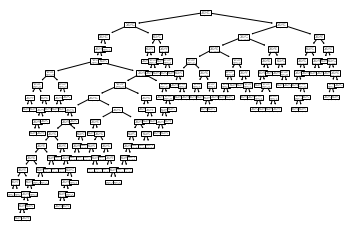

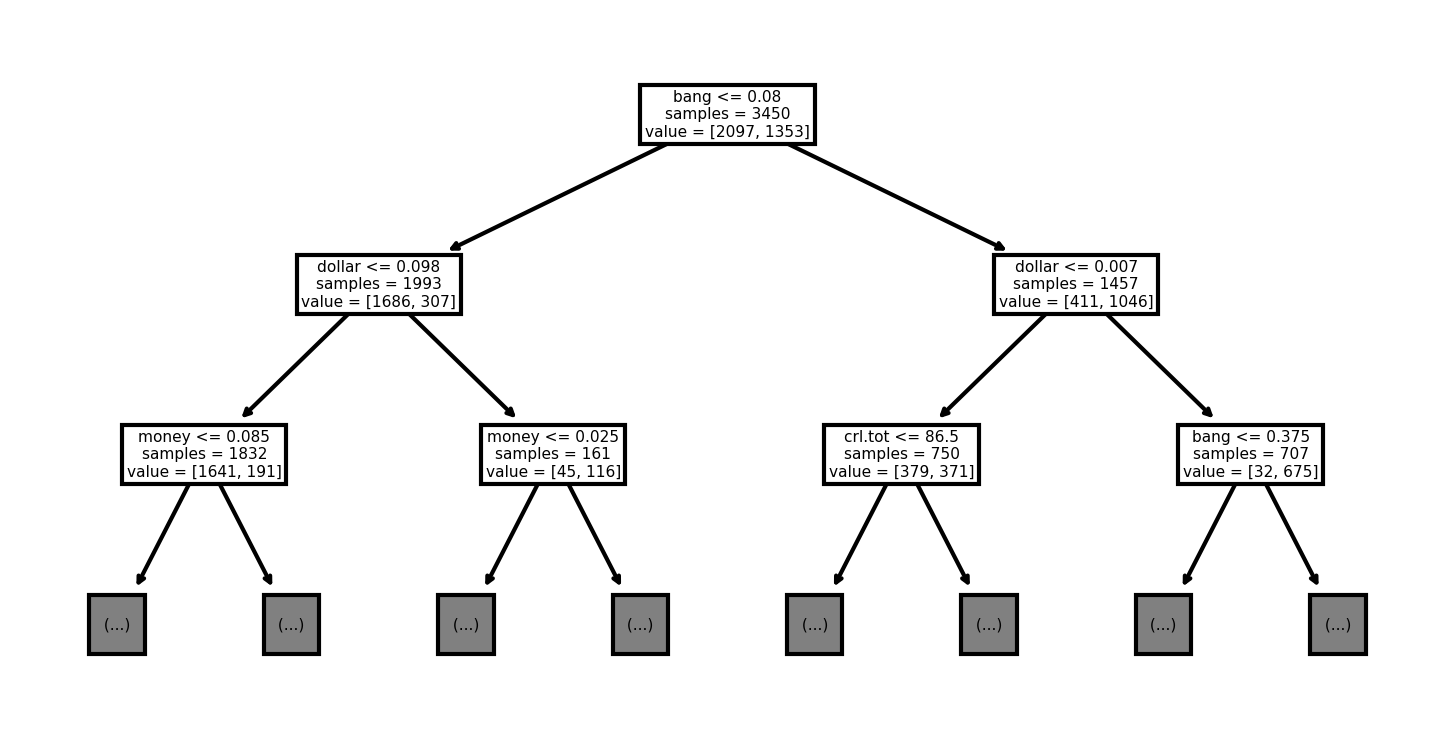

In [22]:
# Visualise the smaller pruned tree
plt.figure()
plot_tree(classifier4, feature_names=X_train.columns)
plt.show()

# Show the first few levels of the tree
plt.figure(figsize=[6,3], dpi=300)
plot_tree(classifier4, max_depth=2, 
          feature_names=X_train.columns, impurity=False)
plt.show()

As you can see in the previous image, the tree is far less complex than the fully (most likely overfitted) tree, which had no minimum constraint on the number of samples in each leaf node. 

By zooming in on the first couple of layers, you can see that the first split is made on the `!` or bang symbol. For interpretation of the decision tree, recall branches to the left indicate that the previous node condition was true and branches to the right mean the previous node condition was false.

In [18]:
# Final test to see how the model performs:
y_pred = classifier4.predict(X_test)
test_score2 = accuracy_score(y_test, y_pred)
print("Accuracy score of the optimal tree = {:2.2%}".format(test_score2)) 
print("Tree depth =",classifier4.get_depth(),'\n'
      "Number of leaves =",classifier4.get_n_leaves())

Accuracy score of the optimal tree = 86.45%
Tree depth = 17 
Number of leaves = 94


The test accuracy is approximately 86.45%. This is only a minor increase in performance; however, in certain scenarios, small improvements are valuable. In most cases, performance will increase more dramatically after pruning.

In [19]:
# The final model to be used for predictions in the future:
best_model = DecisionTreeClassifier(random_state=0, min_samples_leaf=23)
best_model.fit(X, y)
print("Tree depth =",best_model.get_depth(),'\n'
      "Number of leaves =",best_model.get_n_leaves())

Tree depth = 18 
Number of leaves = 125


## Enrichment

Apart from the minimum required samples per terminal node, illustrated in the previous example, there are many other ways to prune a tree. For more information on pruning, explore the scikit-learn DecisionTreeClassifier documentation.
Good pruning parameters to explore are:
1. *max_depth*: The maximum depth a tree should grow. (Note: this could be called a *'hedge'* pruning approach, as opposed to the *'fruit tree'* pruning approach we have used before.)
1. *max_leaf_nodes*: The maximum number of leaves a tree should have.
1. *min_impurity_decrease*: A minimum amount by which the impurity should decrease before adding a new split.
1. *min_samples_split*: A minimum number of samples a leaf should have before splitting it further.
